In [1]:

# before we start, we are setting the start method to fork for convenience
# and for running in a jupyter notebook. This is not always necessary.
import multiprocessing

multiprocessing.set_start_method("fork", force=True)

# Daisy Tutorial
Daisy is a library for processing large volumes in parallel. While other libraries (e.g. dask) can perform similar tasks, daisy is optimized for extremely large volumes, out-of-memory operations, and operations where neighboring blocks should not be run at the same time.

In this tutorial, we will cover:
- daisy terminology and concepts
- running daisy locally with multiprocessing
- running daisy with independent worker processes (e.g., on a compute cluster)
- key features of daisy that make it unique

In [2]:
# Don't forget to install daisy with dependencies for the docs before running this tutorial:
# 
# `pip install daisy[docs]``

## Building Blocks

Daisy is designed for processing volumetric data. Therefore, it has specific ways to describe locations in a volume. We will demonstrate the common terms and utilities using this image of astronaut Eileen Collins.

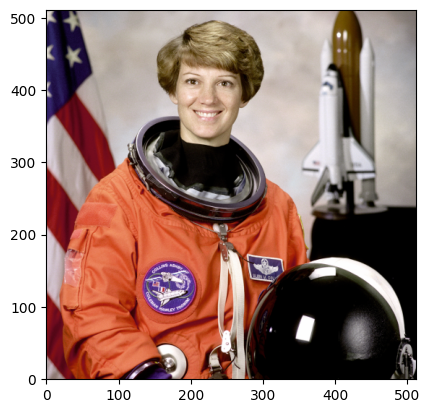

In [3]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt

raw_data = np.flip(data.astronaut(), 0)
axes_image = plt.imshow(raw_data, zorder=1, origin="lower")

###Coordinate
- A daisy Coordinate is essentially a tuple with one value per spatial dimension. In our case, the Coordinates are two-dimensional.
- Daisy coordinates can represent points in the volume, or distances in the volume.
- Daisy mostly passes around abstract placeholders of the data. Therefore, a Coordinate does not contain data, it is simply a pointer to a location in a volume.
- The main difference between a Coordinate and a tuple is that operations (e.g. addition) between Coordinates are performed pointwise, to match the spatial definition.

`daisy.Coordinate` is an alias of [`funlib.geometry.Coordinate`](https://github.com/funkelab/funlib.geometry/blob/main/funlib/geometry/coordinate.py)

Here are some example Coordinates, and a visualization of their location on the Eileen Collins volume.

In [4]:
import daisy

p1 = daisy.Coordinate(10, 10)  # white
p2 = daisy.Coordinate(452, 250)  # yellow
p3 = p2 - p1  # orange

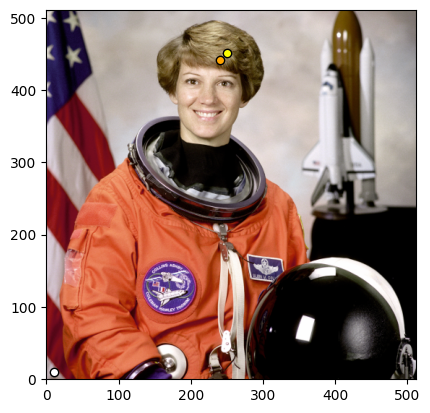

In [5]:
def display_coord(axes, coord, color):
    x = coord[1]
    y = coord[0]
    axes.scatter(x, y, color=color, edgecolors="black", zorder=3)


figure = axes_image.figure
axes = figure.axes[0]
for point, color in zip([p1, p2, p3], ["white", "yellow", "orange"]):
    display_coord(axes, point, color=color)
figure

###Roi
A Roi (Region of interest) is a bounding box in a volume. It is defined by two Coordinates:
- offset: the starting corner of the bounding box relative to the origin
- shape: The extent of the bounding box in each dimension

`daisy.Roi` is an alias of [`funlib.geometry.Roi`](https://github.com/funkelab/funlib.geometry/blob/main/funlib/geometry/roi.py). Rois have operations like grow, shift, and intersect, that represent spatial manipulations

Here are some example Rois and their visualization in our Eileen Collins volume. Remember, the Roi does not contain the data! It is simply a bounding box.

In [6]:
head = daisy.Roi(offset=(320, 150), shape=(180, 150))  # purple
# to get the Roi of the nose, we will shrink the head Roi by a certain amount in x and y on each side of the Roi
# the first argument will move the corner closest to the origin, and the second argument will move the corner furthest from the origin
nose = head.grow(daisy.Coordinate(-60, -55), daisy.Coordinate(-90, -55))  # orange

body = daisy.Roi(offset=p1, shape=(330, 350))  # grey
# to get the neck, we will intersect the body and the head rois
neck = head.intersect(body)  # blue

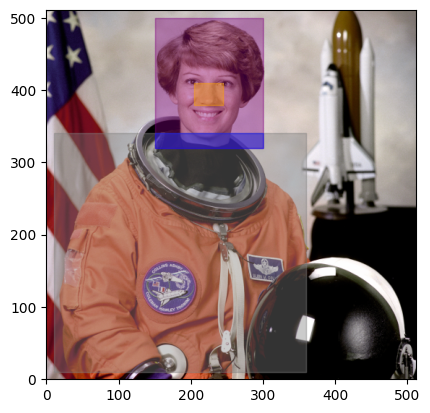

In [7]:
from matplotlib.patches import Rectangle


def display_roi(axes, roi, color):
    xy = (roi.offset[1], roi.offset[0])
    width = roi.shape[1]
    height = roi.shape[0]
    rect = Rectangle(xy, width, height, alpha=0.4, color=color, zorder=2)
    axes.add_patch(rect)


def fresh_image():
    plt.close()
    axes_image = plt.imshow(raw_data, zorder=1, origin="lower")
    figure = axes_image.figure
    axes = figure.axes[0]
    return figure


figure = fresh_image()
for roi, color in zip([head, nose, body, neck], ["purple", "orange", "grey", "blue"]):
    display_roi(figure.axes[0], roi, color=color)

###Array
So far we have seen how to specify regions of the data with Rois and Coordinates, which do not contain any data. However, eventually you will need to access the actual data using your Rois! For this, we use [`funlib.persistence.arrays.Array`](https://github.com/funkelab/funlib.persistence/blob/f5310dddb346585a28f3cb44f577f77d4f5da07c/funlib/persistence/arrays/array.py). If you are familiar with dask, this is the daisy equivalent of dask arrays.

The core information about the `funlib.persistence.arrays.Array` class is that you can slice them with Rois, along with normal numpy-like slicing. However, in order to support this type of slicing, we need to also know the Roi of the whole Array. Here we show you how to create an array from our raw data that is held in memory as a numpy array. However, we highly recommend using a zarr backend, and will show this in our simple example next!

In [8]:
from funlib.persistence.arrays import Array

# daisy Arrays expect the channel dimension first, but our sklearn loaded image has channels last - let's fix that
raw_data_reshaped = raw_data.transpose(2, 0, 1)
print("New data shape:", raw_data_reshaped.shape)

# we need the spatial extend of the data
data_spatial_shape = raw_data_reshaped.shape[1:]
print("Spatial shape:", data_spatial_shape)

# Roi of the whole volume
total_roi = daisy.Roi(offset=(0, 0), shape=data_spatial_shape)
print("Total dataset roi:", total_roi)

raw_array = Array(
    data=raw_data_reshaped,
    offset=total_roi.offset,
    voxel_size=daisy.Coordinate(1, 1),
)

New data shape: (3, 512, 512)
Spatial shape: (512, 512)
Total dataset roi: [0:512, 0:512] (512, 512)


Now we can demonstrate how to access data from an Array using a Roi

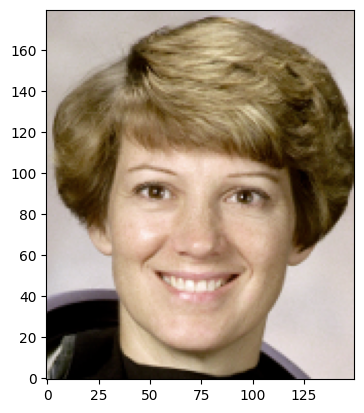

In [9]:
# slicing an Array with a Roi gives you a numpy array
head_data = raw_array[head]
plt.close()
plt.imshow(
    head_data.transpose(1, 2, 0), origin="lower"
)  # need to transpose channels back to the end for matplotlib to work

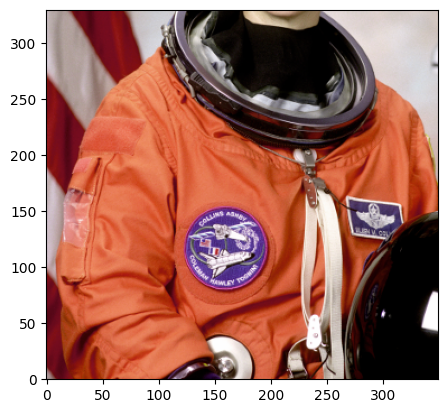

In [10]:
# you can also combine the two steps
body_data = raw_array.to_ndarray(body)
plt.close()
plt.imshow(body_data.transpose(1, 2, 0), origin="lower")

###Block

Daisy is a blockwise task scheduler. Therefore, the concept of a block is central to Daisy. To efficiently process large volumes, Daisy splits the whole volume into a set of adjacent blocks that cover the whole image. These blocks are what is passed between the scheduler and the workers.

A Block is simply a (set of) Roi(s), and does not contain data. In practice, it has additional information that is useful to the daisy server and workers to help them perform their task, which we will decribe below:

Block id: (None, 12)
Block read roi: [128:192, 128:192] (64, 64)
Block write roi: [128:192, 128:192] (64, 64)
Block status: BlockStatus.CREATED


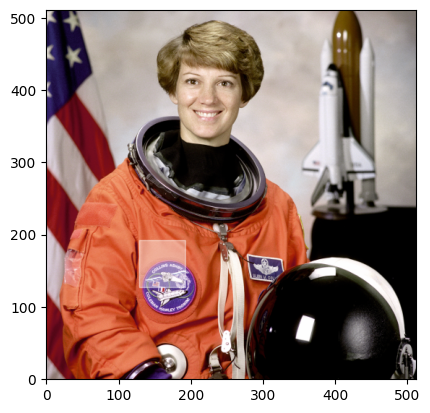

In [11]:
# let's define a Block of our Eileen Collins volume
# In practice, you will never need to make a block - the daisy scheduler will do this for you

block_size = daisy.Coordinate(64, 64)
block_origin = daisy.Coordinate(128, 128)
block_roi = daisy.Roi(block_origin, block_size)

block = daisy.Block(
    total_roi=total_roi,
    read_roi=block_roi,
    write_roi=block_roi,
)

# Here are all the attributes of the block
print(
    "Block id:", block.block_id
)  # a unique ID for each block given the total roi of the volume
print(
    "Block read roi:", block.read_roi
)  # the Roi which represents the location in the volume of the input data to the process
print(
    "Block write roi:", block.write_roi
)  # the Roi which represents the location in the volume where the process should write the output data
print(
    "Block status:", block.status
)  # The status of the block (e.g. created, in progress, succeeded, failed)

# let's look at the write roi of our block on top of the original figure
figure = fresh_image()
display_roi(figure.axes[0], block.write_roi, color="white")

You may be wondering why the block has a read roi and a write roi - this will be illustrated next in our simple daisy example!

## A Simple Example: Local Smoothing
In this next example, we will use gaussian smoothing to illustrate how to parallize a task on your local machine using daisy.

###Dataset Preparation
As mentioned earlier, we highly recommend using a zarr/n5 backend for your volume. Daisy is designed such that no data is transmitted between the worker and the scheduler, including the output of the processing. That means that each worker is responsible for saving the results in the given block write_roi. With a zarr backend, each worker can write to a specific region of the zarr in parallel, assuming that the chunk size is a divisor of and aligned with the write_roi. The zarr dataset must exist before you start scheduling though - we recommend using [`funlib.persistence.prepare_ds`](https://github.com/funkelab/funlib.persistence/blob/f5310dddb346585a28f3cb44f577f77d4f5da07c/funlib/persistence/arrays/datasets.py#L423) function to prepare the dataset. Then later, you can use [`funlib.persistence.open_ds`](https://github.com/funkelab/funlib.persistence/blob/f5310dddb346585a28f3cb44f577f77d4f5da07c/funlib/persistence/arrays/datasets.py#L328) to open the dataset and it will automatically read the metadata and wrap it into a `funlib.persistence.Array`.

In [12]:
import zarr

# convert our data to float, because gaussian smoothing in scikit expects float input and output
# recall that we already reshaped it to put channel dimension first, as the funlib.persistence Array expects
raw_data_float = raw_data_reshaped.astype(np.float32) / 255.0

# store image in zarr container
f = zarr.open("sample_data.zarr", "w")
f["raw"] = raw_data_float
f["raw"].attrs["offset"] = daisy.Coordinate((0, 0))
f["raw"].attrs["resolution"] = daisy.Coordinate(
    (1, 1)
)  # this attribute holds the voxel size

In [13]:
from funlib.persistence import prepare_ds
# prepare an output dataset with a chunk size that is a divisor of the block roi

n_channels = 3  # our output will be an RGB image as well
prepare_ds(
    "sample_data.zarr/smoothed",
    shape=(n_channels, *total_roi.shape),
    offset=total_roi.offset,  # if your output has a different total_roi than your input, you would need to change this
    voxel_size=daisy.Coordinate((1, 1)),
    dtype=raw_data_float.dtype,
    # The write size is important! If you don't set this correctly, your workers will have race conditions
    # when writing to the same file, resulting in expected behavior or weird errors.
    # The prepare_ds function takes care of making zarr chunk sizes that evenly divide your write size
    chunk_shape=(n_channels, *block_size),
)
print("Shape of output dataset:", f["smoothed"].shape)
print("Chunk size in output dataset:", f["smoothed"].chunks)

Shape of output dataset: (3, 512, 512)
Chunk size in output dataset: (3, 64, 64)


###Define our Process Function
When run locally, daisy process functions must take a block as the only argument. Depending on the multiprocessing spawn function settings on your computer, the function might not inherit the imports and variables of the scope where the scheudler is run, so it is always safer to import and define everything inside the function.

Here is an example for smoothing. Generally, daisy process functions have the following three steps:
1. Load the data from disk
2. Process the data
3. Save the result to disk

Note that for now, the worker has to know where to load the data from and save the result to. Later we will show you ways around the rule that the process function must only take the block as input, to allow you to pass that information in when you start the scheduler.

In [14]:
def smooth(block: daisy.Block):
    # imports and hyperaparmeters inside scope, to be safe
    from funlib.persistence.arrays import open_ds
    from skimage import filters

    sigma = 5.0

    # open the raw dataset as an Array
    raw_ds = open_ds(
        "sample_data.zarr/raw",
        "r",
    )
    # Read the data in the block read roi and turn it into a numpy array
    data = raw_ds.to_ndarray(block.read_roi)
    # smooth the data using the gaussian filter from skimage
    smoothed = filters.gaussian(data, sigma=sigma, channel_axis=0)
    # open the output smoothed dataset as an Array
    output_ds = open_ds("sample_data.zarr/smoothed", "a")
    # save the result in the output dataset using the block write roi
    output_ds[block.write_roi] = smoothed

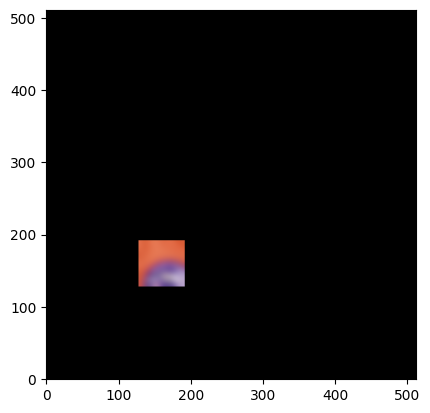

In [15]:
# Let's test the data on our block that we defined earlier and visualize the result
smooth(block)
plt.imshow(
    zarr.open("sample_data.zarr", "r")["smoothed"][:].transpose(1, 2, 0), origin="lower"
)

###Run daisy with local multiprocessing
We are about ready to run daisy! We need to tell the scheduler the following pieces of information:
- The process function, which takes a block as an argument
- The total roi to process (in our case, the whole image)
- The read roi and write roi of each block (the shape and relative offset are what is important, since they will be shifted as a pair to tile the total_roi)
- How many workers to spawn

These pieces of information get wrapped into a [`daisy.Task`](https://github.com/funkelab/daisy/blob/master/daisy/task.py), along with a name for the task. Then the `daisy.run_blockwise` function starts the scheduler, which creates all the blocks that tile the total roi, spawns the workers, distributes the blocks to the workers, and reports if the blocks were successfully processed.

In [16]:
daisy.run_blockwise(
    [
        daisy.Task(
            "Smoothing",  # task name
            process_function=smooth,  # a function that takes a block as argument
            total_roi=total_roi,  # The whole roi of the image
            read_roi=block_roi,  # The roi that the worker should read from
            write_roi=block_roi,  # the roi that the worker should write to
            num_workers=5,
        )
    ]
)

Smoothing ▶:   0%|          | 0/64 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task Smoothing:

    num blocks : 64
    completed ✔: 64 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully


True

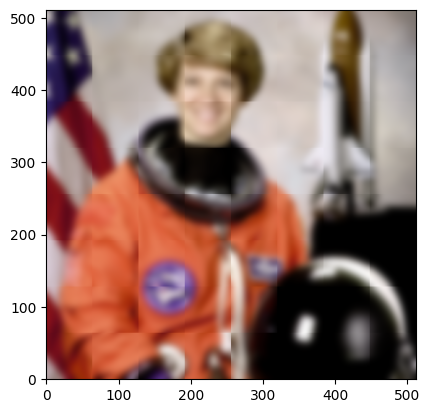

In [17]:
plt.imshow(
    zarr.open("sample_data.zarr", "r")["smoothed"][:].transpose(1, 2, 0), origin="lower"
)

###Take 2: Add context!
The task ran successfully, but you'll notice that there are edge artefacts where the blocks border each other. This is because each worker only sees the inside of the block, and it needs more context to smooth seamlessly between blocks. If we increase the size of the read_roi so that each block sees all pixels that contribute meaningfully to the smoothed values in the interior (write_roi) of the block, the edge artefacts should disappear.

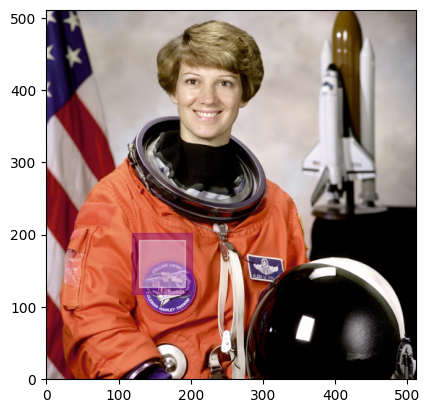

In [18]:
sigma = 5
context = 2 * sigma  # pixels beyond 2*sigma contribute almost nothing to the output
block_read_roi = block_roi.grow(context, context)
block_write_roi = block_roi
# we also grow the total roi by the context, so that the write_rois are still in the same place when we tile
total_read_roi = total_roi.grow(context, context)

block = daisy.Block(
    total_roi=total_roi,
    read_roi=block_read_roi,
    write_roi=block_write_roi,
)

# let's look at the new block rois
figure = fresh_image()
display_roi(figure.axes[0], block.read_roi, color="purple")
display_roi(figure.axes[0], block.write_roi, color="white")

Let's prepare another dataset to store our new and improved smoothing result in. We will be doing this repeatedly through the rest of the tutorial, so we define a helper function to prepare a smoothing result in a given group in the `sample_data.zarr`. We also define a helper function for deleting a dataset, in case you want to re-run a processing step and see a new result.

In [19]:
def prepare_smoothing_ds(group):
    prepare_ds(
        f"sample_data.zarr/{group}",
        shape=(3, *total_roi.shape),
        offset=total_roi.offset,
        voxel_size=daisy.Coordinate((1, 1)),
        dtype=raw_data_float.dtype,
        chunk_shape=(3, *block_size),
    )


def delete_ds(group):
    root = zarr.open("sample_data.zarr", "a")
    if group in root:
        del root[group]


output_group = "smoothed_with_context"
prepare_smoothing_ds(output_group)

Now we have to adapt our process function to crop the output before saving. It would be nice to be able to pass the output group in as an argument, so we will show you a workaround using `functools.partial` to partially evaluate the function. To use this workaround, your process function must have the block as the last argument.

In [20]:
def smooth_in_block(output_group: str, block: daisy.Block):
    # imports and hyperaparmeters inside scope, to be safe
    from funlib.persistence.arrays import open_ds, Array
    from skimage import filters

    sigma = 5.0
    # open the raw dataset as an Array
    raw_ds = open_ds(
        "sample_data.zarr/raw",
        "r",
    )
    # Read the data in the block read roi and turn it into a numpy array
    data = raw_ds.to_ndarray(
        block.read_roi, fill_value=0
    )  # NOTE: this fill value allows you to read outside the total_roi without erroring
    # smooth the data using the gaussian filter from skimage
    smoothed = filters.gaussian(data, sigma=sigma, channel_axis=0)
    # open the output smoothed dataset as an Array
    output_ds = open_ds(f"sample_data.zarr/{output_group}", "a")
    # turn the smoothed result into an Array so we can crop it with a Roi (you can also center crop it by the context manually, but this is easier!)
    smoothed = Array(smoothed, offset=block.read_roi.offset, voxel_size=(1, 1))
    # save the result in the output dataset using the block write roi
    output_ds[block.write_roi] = smoothed.to_ndarray(block.write_roi)

Now we can re-run daisy. Note these changes from the previous example:
- using `functools.partial` to partially evaluate our `smooth_in_block` function , turning it into a function that only takes the block as an argument
- the total_roi is now expanded to include the context, as is the read_roi

In [21]:
from functools import partial

daisy.run_blockwise(
    [
        daisy.Task(
            "Smoothing with context",
            process_function=partial(smooth_in_block, output_group),
            total_roi=total_read_roi,
            read_roi=block_read_roi,
            write_roi=block_write_roi,
            num_workers=5,
        )
    ],
    multiprocessing=False,
)

Smoothing with context ▶:   0%|          | 0/64 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task Smoothing with context:

    num blocks : 64
    completed ✔: 64 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully


defaultdict(daisy.task_state.TaskState,
            {'Smoothing with context': Started: True
             Total Blocks: 64
             Ready: 0
             Processing: 0
             Pending: 0
             Completed: 64
             Skipped: 0
             Failed: 0
             Orphaned: 0})

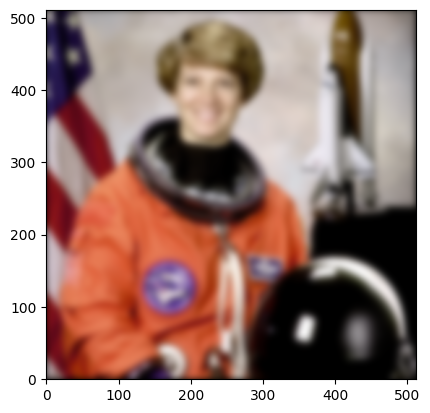

In [22]:
plt.imshow(
    zarr.open("sample_data.zarr", "r")["smoothed_with_context"][:].transpose(1, 2, 0),
    origin="lower",
)

Success! Notice that there is a fade to black at the border, due to the `fill_value=0` argument used when reading the data from the input Array.
Smoothing is poorly defined at the border of the volume - if you want different behavior, you can expand the input array to include extended data of your choice at the border, or shrink the total output roi by the context to only include the section of the output that depends on existing data.

###Conclusion: Dask and Daisy

Congrats! You have learned the basics of Daisy. In this example, we only parallelized the processing using our local computer's resources, and our "volume" was very small.

If your task is similar to this example, you can use dask to do the same task with many fewer lines of code:

In [23]:
%pip install dask

/home/runner/work/daisy/daisy/.venv/bin/python: No module named pip


Note: you may need to restart the kernel to use updated packages.


Raw dask array: dask.array<array, shape=(3, 512, 512), dtype=float32, chunksize=(3, 64, 64), chunktype=numpy.ndarray>


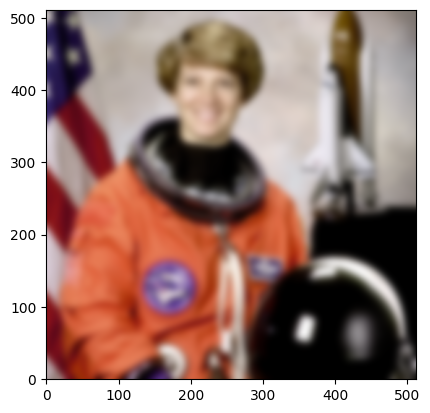

In [24]:
import dask.array as da
from skimage import filters


f = zarr.open("sample_data.zarr", "r")
raw = da.from_array(f["raw"], chunks=(3, 64, 64))
print("Raw dask array:", raw)
sigma = 5.0
context = int(sigma) * 2


def smooth_in_block_dask(x):
    return filters.gaussian(x, sigma=sigma, channel_axis=0)


smoothed = raw.map_overlap(smooth_in_block_dask, depth=(0, context, context))
plt.imshow(smoothed.transpose((1, 2, 0)), origin="lower")

For many situations, both dask and daisy can work well. Indeed, for some tasks, dask is simpler and better suited, as it does for you many things that daisy leaves to you to implement. One key difference between dask and daisy is that in dask, functions are not supposed to have side effects. In daisy, functions can have side effects, allowing blocks to depend on other blocks in the scheduling order (see the last two examples in this tutorial about task chaining and read-write conflicts).

In general, daisy is designed for...
- Cases where you want to be able to pick up where you left off after an error, rather than starting the whole task over (because blocks that finished saved their results to disk)
- Cases where blocks should be executed in a particular order, so that certain blocks see other blocks outputs (without passing the output through the scheduler)
- Cases where the worker function needs setup and teardown that takes longer than processing a block (see our next example!)

## Distributing on the Cluster
While daisy can run locally, it is designed to shine in a cluster computing environment. The only information passed between scheduler and workers are Blocks, which are extremely lightweight and are communicated through TCP. Therefore, workers can be distributed on the cluster with minimal communication overhead.

Let's re-do our smoothing, but this time run each worker as a completely separate subprocess, as would be needed on a cluster. First, we prepare the output dataset.

In [25]:
# first, prepare the dataset
prepare_smoothing_ds("smoothed_subprocess")

Then, we prepare our process function. This time, it has two parts. The first part is the function defined in the cell below, and essentially just calls `subprocess.run` locally or with bsub, as an example compute environment. The second part is the external python script that is actually executed in the `subprocess.run` call.

In [26]:
# new process function to start the worker subprocess
def start_subprocess_worker(cluster="local"):
    import subprocess

    if cluster == "bsub":
        # this is where you define your cluster arguments specific to your task (gpus, cpus, etc)
        num_cpus_per_worker = 1
        subprocess.run(
            [
                "bsub",
                "-I",
                f"-n {num_cpus_per_worker}",
                "python",
                "./tutorial_worker.py",
                "tutorial_config.json",
            ]
        )
    elif cluster == "local":
        subprocess.run(["python", "tutorial_worker.py", "tutorial_config.json"])
    else:
        raise ValueError("Only bsub and local currently supported for this tutorial")

Code from tutorial_worker.py, copied here for convenience (Note: running this cell won't run the code, because it is a markdown cell)
``` python
import daisy
import logging
import time
from funlib.persistence.arrays import open_ds, Array
from skimage import filters
import sys
import json


## This function is the same as the local function, but we can pass as many different arguments as we want, and we don't need to import inside it
def smooth_in_block(block: daisy.Block, config: dict):
    sigma = config["sigma"]
    raw_ds = open_ds(f"{config['input_zarr']}/{config['input_group']}", "r",)
    data = raw_ds.to_ndarray(block.read_roi, fill_value=0)
    smoothed = filters.gaussian(data, sigma=sigma, channel_axis=0)
    output_ds = open_ds(f"{config['output_zarr']}/{config['output_group']}", 'a')
    smoothed = Array(smoothed, offset=block.read_roi.offset, voxel_size=(1, 1))
    output_ds[block.write_roi] = smoothed.to_ndarray(block.write_roi)


if __name__ == "__main__":
    # load a config path or other parameters from the sysargs (recommended to use argparse argument parser for anything more complex)
    config_path = sys.argv[1]

    # load the config
    with open(config_path) as f:
        config = json.load(f)

    # simulate long setup time (e.g. loading a model)
    time.sleep(20)

    # set up the daisy client (this is done by daisy automatically in the local example)
    # it depends on environment variables to determine configuration
    client = daisy.Client()

    while True:
        # ask for a block from the scheduler
        with client.acquire_block() as block:

            # The scheduler will return None when there are no more blocks left
            if block is None:
                break

            # process your block!
            # Note: you can now define whatever function signature you want, rather than being limited to one block argument
            smooth_in_block(block, config)

```

The most important thing to notice about the new worker script is the use of the `client.acquire_block()` function. If you provide a process function that takes a block as input, as we did previously, daisy will create the `daisy.Client`, `while` loop, and `client.acquire_block()` context for you. If you provide a process function with no arguments, the worker is expected to set up the client and request blocks.

Doing the `daisy.Client` set up yourself is helpful when worker startup is expensive - loading saved network weights can be more expensive than actually predicting for one block, so you definitely would not want to load the model separately for each block. We have simulated this by using time.sleep() in the setup of the worker, so when you run the next cell, it should take 20 seconds to start up and then the blocks should process quickly after that.

In [27]:
# note: Must be on submit node to run this with bsub argument
# For Janelians: Don't use the login node to run the scheduler!
#     Instead, use the submit node, which can handle more computational load
tutorial_task = daisy.Task(
    "smoothing_subprocess",
    total_roi=total_read_roi,
    read_roi=block_read_roi,
    write_roi=block_write_roi,
    process_function=partial(start_subprocess_worker, "local"),
    num_workers=2,
)

daisy.run_blockwise([tutorial_task])

smoothing_subprocess ▶:   0%|          | 0/64 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task smoothing_subprocess:

    num blocks : 64
    completed ✔: 64 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully


True

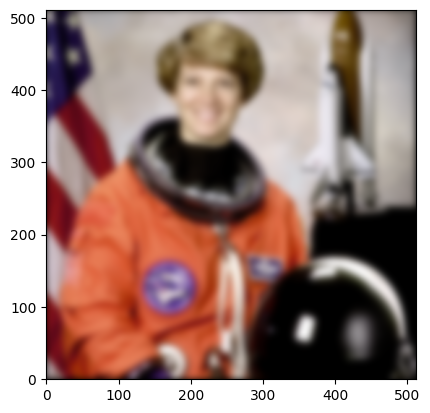

In [28]:
plt.imshow(
    zarr.open("sample_data.zarr", "r")["smoothed_subprocess"][:].transpose(1, 2, 0),
    origin="lower",
)

## Important Features

There are a few more features that you should know about to take full advantage of daisy!

###Fault tolerance and the pre-check function

Even if your code is completely bug-free, things will always go wrong eventually when scaling up to millions of workers. Perhaps your node on the cluster was shared with another process that temporarily hogged too much memory, or you forgot to set a longer timeout and the process was killed after 8 hours. Let's see how daisy can help you handle these issues, by seeing what happens when we add random failures to our smoothing task.

In [29]:
# as always, prepare a new output smoothing  dataset
prepare_smoothing_ds("fault_tolerance")

In [30]:
# simulate failing 50% of the time
def smooth_in_block_with_failure(block: daisy.Block):
    import random
    from funlib.persistence.arrays import open_ds, Array
    from skimage import filters

    if random.random() < 0.5:
        raise ValueError("Simulating random failure")

    sigma = 5.0

    raw_ds = open_ds(
        "sample_data.zarr/raw",
        "r",
    )
    data = raw_ds.to_ndarray(block.read_roi, fill_value=0)
    smoothed = filters.gaussian(data, sigma=sigma, channel_axis=0)

    output_ds = open_ds("sample_data.zarr/fault_tolerance", "a")

    smoothed = Array(smoothed, offset=block.read_roi.offset, voxel_size=(1, 1))
    output_ds[block.write_roi] = smoothed.to_ndarray(block.write_roi)

In [31]:
sigma = 5
context = int(sigma) * 2
read_roi = block_roi.grow(context, context)

daisy.run_blockwise(
    [
        daisy.Task(
            "fault tolerance test",
            process_function=smooth_in_block_with_failure,
            total_roi=total_read_roi,
            read_roi=read_roi,
            write_roi=block_roi,
            read_write_conflict=False,
            num_workers=5,
        )
    ]
)

fault tolerance test ▶:   0%|          | 0/64 [00:00<?, ?blocks/s]

Block fault tolerance test/0 with read ROI [-10:74, -10:74] (84, 84) and write ROI [0:64, 0:64] (64, 64) failed in worker 7 with ValueError('Simulating random failure')


Block fault tolerance test/15 with read ROI [-10:74, 310:394] (84, 84) and write ROI [0:64, 320:384] (64, 64) failed in worker 7 with ValueError('Simulating random failure')


Block fault tolerance test/21 with read ROI [-10:74, 374:458] (84, 84) and write ROI [0:64, 384:448] (64, 64) failed in worker 8 with ValueError('Simulating random failure')


Block fault tolerance test/28 with read ROI [-10:74, 438:522] (84, 84) and write ROI [0:64, 448:512] (64, 64) failed in worker 9 with ValueError('Simulating random failure')


Block fault tolerance test/4 with read ROI [54:138, 54:138] (84, 84) and write ROI [64:128, 64:128] (64, 64) failed in worker 7 with ValueError('Simulating random failure')


Block fault tolerance test/7 with read ROI [54:138, 118:202] (84, 84) and write ROI [64:128, 128:192] (64, 64) failed in worker 11 with ValueError('Simulating random failure')


Block fault tolerance test/22 with read ROI [54:138, 310:394] (84, 84) and write ROI [64:128, 320:384] (64, 64) failed in worker 7 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=37805:task_id=fault tolerance test:worker_id=7 failed too many times, restarting this worker...


Block fault tolerance test/5 with read ROI [118:202, -10:74] (84, 84) and write ROI [128:192, 0:64] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/12 with read ROI [118:202, 118:202] (84, 84) and write ROI [128:192, 128:192] (64, 64) failed in worker 9 with ValueError('Simulating random failure')


Block fault tolerance test/17 with read ROI [118:202, 182:266] (84, 84) and write ROI [128:192, 192:256] (64, 64) failed in worker 11 with ValueError('Simulating random failure')


Block fault tolerance test/23 with read ROI [118:202, 246:330] (84, 84) and write ROI [128:192, 256:320] (64, 64) failed in worker 10 with ValueError('Simulating random failure')


Block fault tolerance test/30 with read ROI [118:202, 310:394] (84, 84) and write ROI [128:192, 320:384] (64, 64) failed in worker 9 with ValueError('Simulating random failure')


Block fault tolerance test/9 with read ROI [182:266, -10:74] (84, 84) and write ROI [192:256, 0:64] (64, 64) failed in worker 10 with ValueError('Simulating random failure')


Block fault tolerance test/31 with read ROI [182:266, 246:330] (84, 84) and write ROI [192:256, 256:320] (64, 64) failed in worker 10 with ValueError('Simulating random failure')


Block fault tolerance test/58 with read ROI [182:266, 438:522] (84, 84) and write ROI [192:256, 448:512] (64, 64) failed in worker 12 with ValueError('Simulating random failure')


Block fault tolerance test/19 with read ROI [246:330, 54:138] (84, 84) and write ROI [256:320, 64:128] (64, 64) failed in worker 10 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=37805:task_id=fault tolerance test:worker_id=10 failed too many times, restarting this worker...


Block fault tolerance test/25 with read ROI [246:330, 118:202] (84, 84) and write ROI [256:320, 128:192] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/32 with read ROI [246:330, 182:266] (84, 84) and write ROI [256:320, 192:256] (64, 64) failed in worker 11 with ValueError('Simulating random failure')


Block fault tolerance test/40 with read ROI [246:330, 246:330] (84, 84) and write ROI [256:320, 256:320] (64, 64) failed in worker 12 with ValueError('Simulating random failure')


Block fault tolerance test/49 with read ROI [246:330, 310:394] (84, 84) and write ROI [256:320, 320:384] (64, 64) failed in worker 9 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=37805:task_id=fault tolerance test:worker_id=9 failed too many times, restarting this worker...


Block fault tolerance test/59 with read ROI [246:330, 374:458] (84, 84) and write ROI [256:320, 384:448] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/70 with read ROI [246:330, 438:522] (84, 84) and write ROI [256:320, 448:512] (64, 64) failed in worker 8 with ValueError('Simulating random failure')


Block fault tolerance test/41 with read ROI [310:394, 182:266] (84, 84) and write ROI [320:384, 192:256] (64, 64) failed in worker 12 with ValueError('Simulating random failure')


Block fault tolerance test/50 with read ROI [310:394, 246:330] (84, 84) and write ROI [320:384, 256:320] (64, 64) failed in worker 11 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=37805:task_id=fault tolerance test:worker_id=11 failed too many times, restarting this worker...


Block fault tolerance test/71 with read ROI [310:394, 374:458] (84, 84) and write ROI [320:384, 384:448] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/27 with read ROI [374:458, -10:74] (84, 84) and write ROI [384:448, 0:64] (64, 64) failed in worker 14 with ValueError('Simulating random failure')


Block fault tolerance test/34 with read ROI [374:458, 54:138] (84, 84) and write ROI [384:448, 64:128] (64, 64) failed in worker 12 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=37805:task_id=fault tolerance test:worker_id=12 failed too many times, restarting this worker...


Block fault tolerance test/42 with read ROI [374:458, 118:202] (84, 84) and write ROI [384:448, 128:192] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/51 with read ROI [374:458, 182:266] (84, 84) and write ROI [384:448, 192:256] (64, 64) failed in worker 14 with ValueError('Simulating random failure')


Block fault tolerance test/35 with read ROI [438:522, -10:74] (84, 84) and write ROI [448:512, 0:64] (64, 64) failed in worker 13 with ValueError('Simulating random failure')


Block fault tolerance test/43 with read ROI [438:522, 54:138] (84, 84) and write ROI [448:512, 64:128] (64, 64) failed in worker 8 with ValueError('Simulating random failure')


Block fault tolerance test/62 with read ROI [438:522, 182:266] (84, 84) and write ROI [448:512, 192:256] (64, 64) failed in worker 14 with ValueError('Simulating random failure')


Block fault tolerance test/73 with read ROI [438:522, 246:330] (84, 84) and write ROI [448:512, 256:320] (64, 64) failed in worker 13 with ValueError('Simulating random failure')


Block fault tolerance test/0 with read ROI [-10:74, -10:74] (84, 84) and write ROI [0:64, 0:64] (64, 64) failed in worker 16 with ValueError('Simulating random failure')


Block fault tolerance test/15 with read ROI [-10:74, 310:394] (84, 84) and write ROI [0:64, 320:384] (64, 64) failed in worker 13 with ValueError('Simulating random failure')


Block fault tolerance test/28 with read ROI [-10:74, 438:522] (84, 84) and write ROI [0:64, 448:512] (64, 64) failed in worker 15 with ValueError('Simulating random failure')


Block fault tolerance test/5 with read ROI [118:202, -10:74] (84, 84) and write ROI [128:192, 0:64] (64, 64) failed in worker 15 with ValueError('Simulating random failure')


Block fault tolerance test/17 with read ROI [118:202, 182:266] (84, 84) and write ROI [128:192, 192:256] (64, 64) failed in worker 16 with ValueError('Simulating random failure')


Block fault tolerance test/9 with read ROI [182:266, -10:74] (84, 84) and write ROI [192:256, 0:64] (64, 64) failed in worker 14 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=37805:task_id=fault tolerance test:worker_id=14 failed too many times, restarting this worker...


Block fault tolerance test/58 with read ROI [182:266, 438:522] (84, 84) and write ROI [192:256, 448:512] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/19 with read ROI [246:330, 54:138] (84, 84) and write ROI [256:320, 64:128] (64, 64) failed in worker 16 with ValueError('Simulating random failure')


Block fault tolerance test/25 with read ROI [246:330, 118:202] (84, 84) and write ROI [256:320, 128:192] (64, 64) failed in worker 13 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=37805:task_id=fault tolerance test:worker_id=13 failed too many times, restarting this worker...


Block fault tolerance test/40 with read ROI [246:330, 246:330] (84, 84) and write ROI [256:320, 256:320] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/32 with read ROI [246:330, 182:266] (84, 84) and write ROI [256:320, 192:256] (64, 64) failed in worker 15 with ValueError('Simulating random failure')


Block fault tolerance test/59 with read ROI [246:330, 374:458] (84, 84) and write ROI [256:320, 384:448] (64, 64) failed in worker 8 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=37805:task_id=fault tolerance test:worker_id=8 failed too many times, restarting this worker...


Block fault tolerance test/70 with read ROI [246:330, 438:522] (84, 84) and write ROI [256:320, 448:512] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/41 with read ROI [310:394, 182:266] (84, 84) and write ROI [320:384, 192:256] (64, 64) failed in worker 15 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=37805:task_id=fault tolerance test:worker_id=15 failed too many times, restarting this worker...


Block fault tolerance test/50 with read ROI [310:394, 246:330] (84, 84) and write ROI [320:384, 256:320] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/71 with read ROI [310:394, 374:458] (84, 84) and write ROI [320:384, 384:448] (64, 64) failed in worker 17 with ValueError('Simulating random failure')


Block fault tolerance test/34 with read ROI [374:458, 54:138] (84, 84) and write ROI [384:448, 64:128] (64, 64) failed in worker 18 with ValueError('Simulating random failure')


Block fault tolerance test/51 with read ROI [374:458, 182:266] (84, 84) and write ROI [384:448, 192:256] (64, 64) failed in worker 16 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=37805:task_id=fault tolerance test:worker_id=16 failed too many times, restarting this worker...


Block fault tolerance test/35 with read ROI [438:522, -10:74] (84, 84) and write ROI [448:512, 0:64] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/43 with read ROI [438:522, 54:138] (84, 84) and write ROI [448:512, 64:128] (64, 64) failed in worker 19 with ValueError('Simulating random failure')


Block fault tolerance test/62 with read ROI [438:522, 182:266] (84, 84) and write ROI [448:512, 192:256] (64, 64) failed in worker 18 with ValueError('Simulating random failure')


Block fault tolerance test/0 with read ROI [-10:74, -10:74] (84, 84) and write ROI [0:64, 0:64] (64, 64) failed in worker 17 with ValueError('Simulating random failure')


Block fault tolerance test/15 with read ROI [-10:74, 310:394] (84, 84) and write ROI [0:64, 320:384] (64, 64) failed in worker 19 with ValueError('Simulating random failure')


Block fault tolerance test/17 with read ROI [118:202, 182:266] (84, 84) and write ROI [128:192, 192:256] (64, 64) failed in worker 20 with ValueError('Simulating random failure')


Block fault tolerance test/58 with read ROI [182:266, 438:522] (84, 84) and write ROI [192:256, 448:512] (64, 64) failed in worker 21 with ValueError('Simulating random failure')


Block fault tolerance test/19 with read ROI [246:330, 54:138] (84, 84) and write ROI [256:320, 64:128] (64, 64) failed in worker 18 with ValueError('Simulating random failure')


Block fault tolerance test/59 with read ROI [246:330, 374:458] (84, 84) and write ROI [256:320, 384:448] (64, 64) failed in worker 19 with ValueError('Simulating random failure')


Block fault tolerance test/41 with read ROI [310:394, 182:266] (84, 84) and write ROI [320:384, 192:256] (64, 64) failed in worker 17 with ValueError('Simulating random failure')



Execution Summary
-----------------

  Task fault tolerance test:

    num blocks : 64
    completed ✔: 57 (skipped 0)
    failed    ✗: 7
    orphaned  ∅: 0

    Failed Blocks:

      block 0 in worker 7 with exception ValueError('Simulating random failure')
      block 15 in worker 7 with exception ValueError('Simulating random failure')
      block 21 in worker 8 with exception ValueError('Simulating random failure')
      block 28 in worker 9 with exception ValueError('Simulating random failure')
      block 4 in worker 7 with exception ValueError('Simulating random failure')
      block 7 in worker 11 with exception ValueError('Simulating random failure')
      block 22 in worker 7 with exception ValueError('Simulating random failure')
      block 12 in worker 9 with exception ValueError('Simulating random failure')
      block 17 in worker 11 with exception ValueError('Simulating random failure')
      block 23 in worker 10 with exception ValueError('Simulating random failure')
 

True

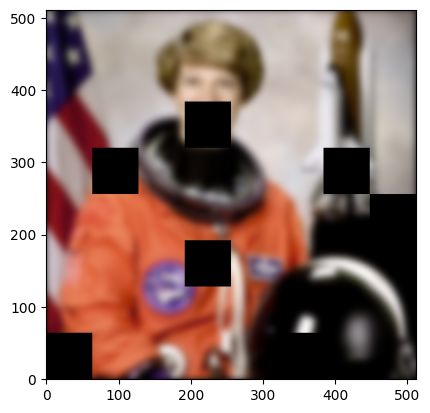

In [32]:
plt.imshow(
    zarr.open("sample_data.zarr", "r")["fault_tolerance"][:].transpose(1, 2, 0),
    origin="lower",
)

Debugging multi-process code is inherently difficult, but daisy tries to provide as much information as possible. First, you see the progress bar, which also reports the number of blocks at each state, including failed blocks. Any worker error messages are also logged to the scheduler log, although not the full traceback. Upon completion, daisy provides an error summary, which informs you of the final status of all the blocks, and points you to the full output and error logs for each worker, which can be found in `daisy_logs/<task_name>`. The worker error log will contain the full traceback for debugging the exact source of an error.

You may have noticed that while we coded the task to fail 50% of the time, much more than 50% of the blocks succeeded. This is because daisy by default retries each block 3 times (on different workers) before marking it as failed, to deal gracefully with random error.  We will re-run this example, but set max_retries=0 to see the effect of this parameter.

In [33]:
# delete and re-create the dataset, so that we start from zeros again
delete_ds("fault_tolerance")
prepare_smoothing_ds("fault_tolerance")

In [34]:
daisy.run_blockwise(
    [
        daisy.Task(
            "fault tolerance test",
            process_function=smooth_in_block_with_failure,
            total_roi=total_read_roi,
            read_roi=read_roi,
            write_roi=block_roi,
            read_write_conflict=False,
            max_retries=0,
            num_workers=5,
        )
    ]
)

fault tolerance test ▶:   0%|          | 0/64 [00:00<?, ?blocks/s]

Block fault tolerance test/6 with read ROI [-10:74, 182:266] (84, 84) and write ROI [0:64, 192:256] (64, 64) failed in worker 25 with ValueError('Simulating random failure')


Block fault tolerance test/28 with read ROI [-10:74, 438:522] (84, 84) and write ROI [0:64, 448:512] (64, 64) failed in worker 25 with ValueError('Simulating random failure')


Block fault tolerance test/16 with read ROI [54:138, 246:330] (84, 84) and write ROI [64:128, 256:320] (64, 64) failed in worker 23 with ValueError('Simulating random failure')


Block fault tolerance test/29 with read ROI [54:138, 374:458] (84, 84) and write ROI [64:128, 384:448] (64, 64) failed in worker 26 with ValueError('Simulating random failure')


Block fault tolerance test/5 with read ROI [118:202, -10:74] (84, 84) and write ROI [128:192, 0:64] (64, 64) failed in worker 22 with ValueError('Simulating random failure')


Block fault tolerance test/12 with read ROI [118:202, 118:202] (84, 84) and write ROI [128:192, 128:192] (64, 64) failed in worker 24 with ValueError('Simulating random failure')


Block fault tolerance test/23 with read ROI [118:202, 246:330] (84, 84) and write ROI [128:192, 256:320] (64, 64) failed in worker 22 with ValueError('Simulating random failure')


Block fault tolerance test/18 with read ROI [182:266, 118:202] (84, 84) and write ROI [192:256, 128:192] (64, 64) failed in worker 23 with ValueError('Simulating random failure')


Block fault tolerance test/24 with read ROI [182:266, 182:266] (84, 84) and write ROI [192:256, 192:256] (64, 64) failed in worker 24 with ValueError('Simulating random failure')


Block fault tolerance test/31 with read ROI [182:266, 246:330] (84, 84) and write ROI [192:256, 256:320] (64, 64) failed in worker 25 with ValueError('Simulating random failure')


Block fault tolerance test/39 with read ROI [182:266, 310:394] (84, 84) and write ROI [192:256, 320:384] (64, 64) failed in worker 26 with ValueError('Simulating random failure')


Block fault tolerance test/25 with read ROI [246:330, 118:202] (84, 84) and write ROI [256:320, 128:192] (64, 64) failed in worker 26 with ValueError('Simulating random failure')


Block fault tolerance test/40 with read ROI [246:330, 246:330] (84, 84) and write ROI [256:320, 256:320] (64, 64) failed in worker 23 with ValueError('Simulating random failure')


Block fault tolerance test/49 with read ROI [246:330, 310:394] (84, 84) and write ROI [256:320, 320:384] (64, 64) failed in worker 24 with ValueError('Simulating random failure')


Block fault tolerance test/20 with read ROI [310:394, -10:74] (84, 84) and write ROI [320:384, 0:64] (64, 64) failed in worker 23 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=34689:task_id=fault tolerance test:worker_id=23 failed too many times, restarting this worker...


Block fault tolerance test/41 with read ROI [310:394, 182:266] (84, 84) and write ROI [320:384, 192:256] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/26 with read ROI [310:394, 54:138] (84, 84) and write ROI [320:384, 64:128] (64, 64) failed in worker 22 with ValueError('Simulating random failure')


Block fault tolerance test/60 with read ROI [310:394, 310:394] (84, 84) and write ROI [320:384, 320:384] (64, 64) failed in worker 26 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=34689:task_id=fault tolerance test:worker_id=26 failed too many times, restarting this worker...


Block fault tolerance test/71 with read ROI [310:394, 374:458] (84, 84) and write ROI [320:384, 384:448] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/51 with read ROI [374:458, 182:266] (84, 84) and write ROI [384:448, 192:256] (64, 64) failed in worker 27 with ValueError('Simulating random failure')


Block fault tolerance test/61 with read ROI [374:458, 246:330] (84, 84) and write ROI [384:448, 256:320] (64, 64) failed in worker 24 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=34689:task_id=fault tolerance test:worker_id=24 failed too many times, restarting this worker...


Block fault tolerance test/84 with read ROI [374:458, 374:458] (84, 84) and write ROI [384:448, 384:448] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/43 with read ROI [438:522, 54:138] (84, 84) and write ROI [448:512, 64:128] (64, 64) failed in worker 22 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=34689:task_id=fault tolerance test:worker_id=22 failed too many times, restarting this worker...


Block fault tolerance test/52 with read ROI [438:522, 118:202] (84, 84) and write ROI [448:512, 128:192] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/62 with read ROI [438:522, 182:266] (84, 84) and write ROI [448:512, 192:256] (64, 64) failed in worker 25 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=34689:task_id=fault tolerance test:worker_id=25 failed too many times, restarting this worker...


Block fault tolerance test/73 with read ROI [438:522, 246:330] (84, 84) and write ROI [448:512, 256:320] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/85 with read ROI [438:522, 310:394] (84, 84) and write ROI [448:512, 320:384] (64, 64) failed in worker 28 with ValueError('Simulating random failure')



Execution Summary
-----------------

  Task fault tolerance test:

    num blocks : 64
    completed ✔: 37 (skipped 0)
    failed    ✗: 27
    orphaned  ∅: 0

    Failed Blocks:

      block 6 in worker 25 with exception ValueError('Simulating random failure')
      block 28 in worker 25 with exception ValueError('Simulating random failure')
      block 16 in worker 23 with exception ValueError('Simulating random failure')
      block 29 in worker 26 with exception ValueError('Simulating random failure')
      block 5 in worker 22 with exception ValueError('Simulating random failure')
      block 12 in worker 24 with exception ValueError('Simulating random failure')
      block 23 in worker 22 with exception ValueError('Simulating random failure')
      block 18 in worker 23 with exception ValueError('Simulating random failure')
      block 24 in worker 24 with exception ValueError('Simulating random failure')
      block 31 in worker 25 with exception ValueError('Simulating random fa

True

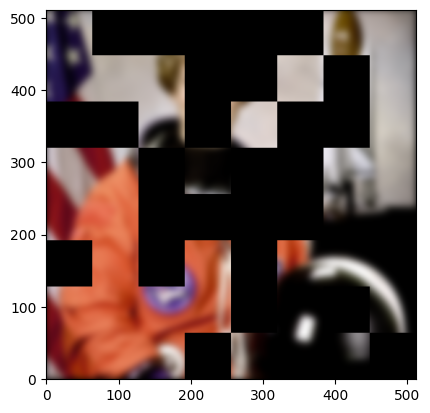

In [35]:
plt.imshow(
    zarr.open("sample_data.zarr", "r")["fault_tolerance"][:].transpose(1, 2, 0),
    origin="lower",
)

Now we should see a success rate closer to what we would expect. You might notice in the logs a message like ```Worker hostname=...:port=..:task_id=fault tolerance test:worker_id=... failed too many times, restarting this worker...```, which shows another way that daisy is robust to pseudo-random errors. If a specific worker fails multiple times, daisy will assume something might have gone wrong with that worker (e.g. GPU memory taken by another process that the cluster scheduler was not aware of). The scheduler will shut down and restart the worker, and retry the blocks that failed on that worker. So daisy is very robust to random error.

But what about non-random error, like stopping after 8 hours? If you don't want to re-process all the already processed blocks from a prior run, you can write a function that takes a block and checks if it is complete, and pass it to the scheduler. The scheduler will run this check function on each block and skip the block if the check function returns true.

Here is an example check function for our smoothing task, that checks if there are any non-zero values in the output array

In [36]:
def check_complete(output_group, block):
    from funlib.persistence.arrays import open_ds
    import numpy as np

    output_ds = open_ds(f"sample_data.zarr/{output_group}", "r")
    if np.max(output_ds.to_ndarray(block.write_roi)) > 0:
        return True
    else:
        return False

If we re-run the task, but with the check function provided, you should see in the execution summary that all the blocks that finished before are skipped. You can continue re-running until you reach 100% completion, without ever re-processing those same blocks

In [37]:
daisy.run_blockwise(
    [
        daisy.Task(
            "fault tolerance test",
            process_function=smooth_in_block_with_failure,
            total_roi=total_read_roi,
            read_roi=read_roi,
            write_roi=block_roi,
            read_write_conflict=False,
            max_retries=1,
            num_workers=5,
            check_function=partial(check_complete, "fault_tolerance"),
        )
    ]
)

fault tolerance test ▶:   0%|          | 0/64 [00:00<?, ?blocks/s]

Block fault tolerance test/6 with read ROI [-10:74, 182:266] (84, 84) and write ROI [0:64, 192:256] (64, 64) failed in worker 32 with ValueError('Simulating random failure')


Block fault tolerance test/23 with read ROI [118:202, 246:330] (84, 84) and write ROI [128:192, 256:320] (64, 64) failed in worker 34 with ValueError('Simulating random failure')


Block fault tolerance test/18 with read ROI [182:266, 118:202] (84, 84) and write ROI [192:256, 128:192] (64, 64) failed in worker 35 with ValueError('Simulating random failure')


Block fault tolerance test/24 with read ROI [182:266, 182:266] (84, 84) and write ROI [192:256, 192:256] (64, 64) failed in worker 36 with ValueError('Simulating random failure')


Block fault tolerance test/39 with read ROI [182:266, 310:394] (84, 84) and write ROI [192:256, 320:384] (64, 64) failed in worker 34 with ValueError('Simulating random failure')


Block fault tolerance test/25 with read ROI [246:330, 118:202] (84, 84) and write ROI [256:320, 128:192] (64, 64) failed in worker 32 with ValueError('Simulating random failure')


Block fault tolerance test/40 with read ROI [246:330, 246:330] (84, 84) and write ROI [256:320, 256:320] (64, 64) failed in worker 35 with ValueError('Simulating random failure')


Block fault tolerance test/20 with read ROI [310:394, -10:74] (84, 84) and write ROI [320:384, 0:64] (64, 64) failed in worker 34 with ValueError('Simulating random failure')


Block fault tolerance test/26 with read ROI [310:394, 54:138] (84, 84) and write ROI [320:384, 64:128] (64, 64) failed in worker 33 with ValueError('Simulating random failure')


Block fault tolerance test/41 with read ROI [310:394, 182:266] (84, 84) and write ROI [320:384, 192:256] (64, 64) failed in worker 32 with ValueError('Simulating random failure')


Block fault tolerance test/60 with read ROI [310:394, 310:394] (84, 84) and write ROI [320:384, 320:384] (64, 64) failed in worker 35 with ValueError('Simulating random failure')


Block fault tolerance test/51 with read ROI [374:458, 182:266] (84, 84) and write ROI [384:448, 192:256] (64, 64) failed in worker 34 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=33831:task_id=fault tolerance test:worker_id=34 failed too many times, restarting this worker...


Block fault tolerance test/61 with read ROI [374:458, 246:330] (84, 84) and write ROI [384:448, 256:320] (64, 64) failed in worker 33 with ValueError('Simulating random failure')


Block fault tolerance test/84 with read ROI [374:458, 374:458] (84, 84) and write ROI [384:448, 384:448] (64, 64) failed in worker 32 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=33831:task_id=fault tolerance test:worker_id=32 failed too many times, restarting this worker...


Block fault tolerance test/52 with read ROI [438:522, 118:202] (84, 84) and write ROI [448:512, 128:192] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/85 with read ROI [438:522, 310:394] (84, 84) and write ROI [448:512, 320:384] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/62 with read ROI [438:522, 182:266] (84, 84) and write ROI [448:512, 192:256] (64, 64) failed in worker 36 with ValueError('Simulating random failure')


Block fault tolerance test/6 with read ROI [-10:74, 182:266] (84, 84) and write ROI [0:64, 192:256] (64, 64) failed in worker 35 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=33831:task_id=fault tolerance test:worker_id=35 failed too many times, restarting this worker...


Block fault tolerance test/24 with read ROI [182:266, 182:266] (84, 84) and write ROI [192:256, 192:256] (64, 64) was lost, returning it to scheduler


Block fault tolerance test/18 with read ROI [182:266, 118:202] (84, 84) and write ROI [192:256, 128:192] (64, 64) failed in worker 33 with ValueError('Simulating random failure')


Block fault tolerance test/39 with read ROI [182:266, 310:394] (84, 84) and write ROI [192:256, 320:384] (64, 64) failed in worker 37 with ValueError('Simulating random failure')


Block fault tolerance test/40 with read ROI [246:330, 246:330] (84, 84) and write ROI [256:320, 256:320] (64, 64) failed in worker 36 with ValueError('Simulating random failure')


Block fault tolerance test/20 with read ROI [310:394, -10:74] (84, 84) and write ROI [320:384, 0:64] (64, 64) failed in worker 38 with ValueError('Simulating random failure')


Block fault tolerance test/26 with read ROI [310:394, 54:138] (84, 84) and write ROI [320:384, 64:128] (64, 64) failed in worker 37 with ValueError('Simulating random failure')


Block fault tolerance test/84 with read ROI [374:458, 374:458] (84, 84) and write ROI [384:448, 384:448] (64, 64) failed in worker 37 with ValueError('Simulating random failure')


Block fault tolerance test/52 with read ROI [438:522, 118:202] (84, 84) and write ROI [448:512, 128:192] (64, 64) failed in worker 36 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=33831:task_id=fault tolerance test:worker_id=36 failed too many times, restarting this worker...


Block fault tolerance test/85 with read ROI [438:522, 310:394] (84, 84) and write ROI [448:512, 320:384] (64, 64) failed in worker 33 with ValueError('Simulating random failure')


Worker logdir=daisy_logs:hostname=10.1.0.166:port=33831:task_id=fault tolerance test:worker_id=33 failed too many times, restarting this worker...


Block fault tolerance test/62 with read ROI [438:522, 182:266] (84, 84) and write ROI [448:512, 192:256] (64, 64) failed in worker 38 with ValueError('Simulating random failure')



Execution Summary
-----------------

  Task fault tolerance test:

    num blocks : 64
    completed ✔: 53 (skipped 37)
    failed    ✗: 11
    orphaned  ∅: 0

    Failed Blocks:

      block 6 in worker 32 with exception ValueError('Simulating random failure')
      block 23 in worker 34 with exception ValueError('Simulating random failure')
      block 18 in worker 35 with exception ValueError('Simulating random failure')
      block 24 in worker 36 with exception ValueError('Simulating random failure')
      block 39 in worker 34 with exception ValueError('Simulating random failure')
      block 25 in worker 32 with exception ValueError('Simulating random failure')
      block 40 in worker 35 with exception ValueError('Simulating random failure')
      block 20 in worker 34 with exception ValueError('Simulating random failure')
      block 26 in worker 33 with exception ValueError('Simulating random failure')
      block 41 in worker 32 with exception ValueError('Simulating random 

True

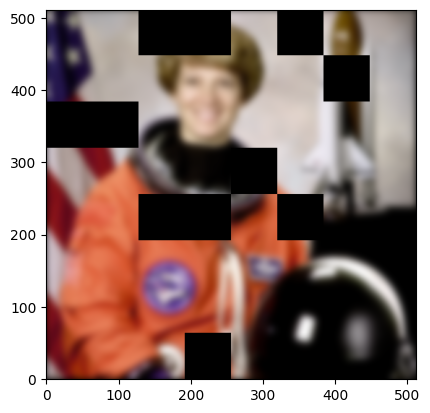

In [38]:
plt.imshow(
    zarr.open("sample_data.zarr", "r")["fault_tolerance"][:].transpose(1, 2, 0),
    origin="lower",
)

Unfortunately, this is a pretty inefficient pre-check function, because you have to actually read the output data to see if the block is completed. Since this will be run on the scheduler on every block before it is passed to a worker, it might not even be faster than just re-processing the blocks (which is at least distributed).

If you plan to have extremely long running jobs that might get killed in the middle, we recommend including a step in your process function after you write out the result of a block, in which you write out the block id to a database or a file. Then, the pre-check function can just check if the block id is in the file system or database, which is much faster than reading the actual data.

###Task chaining

Frequently, image processing pipelines involve multiple tasks, where some tasks depend on the output of other tasks. For example, we have a function to segment out instances of blue objects in an image, and we want to apply it after smoothing. We can define two tasks and run them sequentially in the scheduler. Daisy will even begin the second task as soon as a single block can be run, rather than waiting for the first task to fully complete before starting the second task.

In [39]:
%pip install opencv-python

/home/runner/work/daisy/daisy/.venv/bin/python: No module named pip


Note: you may need to restart the kernel to use updated packages.


In [40]:
# here is our function to segment blue objects
# it is just thresholding in HSV space, so unlike smoothing, the neighboring pixels do not affect the outcome
# There is probably a nicer way to get the image into hsv space, but this gets the job done!
def segment_blue_objects(input_group, output_group, block):
    import cv2
    from funlib.persistence.arrays import open_ds
    import numpy as np
    import skimage

    # load the data as usual
    input_ds = open_ds(
        f"sample_data.zarr/{input_group}",
        "r",
    )
    data = input_ds.to_ndarray(block.read_roi)

    # massage the data into open cv hsv format :/
    back_to_skimage = (data.transpose(1, 2, 0) * 255).astype(np.uint8)
    cv2_image = cv2.cvtColor(
        skimage.util.img_as_ubyte(back_to_skimage), cv2.COLOR_RGB2BGR
    )
    hsv_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2HSV)

    # Define the color range for detection
    lower_blue = np.array([100, 30, 0])
    upper_blue = np.array([150, 255, 255])

    # Threshold the image to get only blue colors
    mask = cv2.inRange(hsv_image, lower_blue, upper_blue)  # this returns 0 and 255
    mask = mask.astype(np.uint32)
    mask = mask // 255  # turn into 0/1 labels

    # give each connected component its own instance segmentation label
    labels = skimage.measure.label(mask)

    # get a unique ID for each element in the whole volume (avoid repeats between blocks)
    max_number_obj = (
        128 * 128
    )  # This number is an upper bound on the maximum number of objects in a block
    block_id_mask = mask * (block.block_id[1] * max_number_obj)
    labels = labels + block_id_mask

    # save the output
    output_ds = open_ds(f"sample_data.zarr/{output_group}", "a")
    output_ds[block.write_roi] = labels

Previously, we always defined our `daisy.Task` inside the call to `daisy.run_blockwise`. Now, we need to save our smoothing task in a variable so we can reference it as a dependency our segmentation task.

In [41]:
# as always, prepare the output dataset
delete_ds("smoothed_for_seg")
prepare_smoothing_ds("smoothed_for_seg")

# same smoothing task as usual, with unqiue output dataset
smoothing_task = daisy.Task(
    "smooth_for_seg",
    process_function=partial(smooth_in_block, "smoothed_for_seg"),
    total_roi=total_read_roi,
    read_roi=read_roi,
    write_roi=block_roi,
    num_workers=3,
    read_write_conflict=False,
    check_function=partial(check_complete, "smoothed_for_seg"),
)

Next, we make our segmentatation task. Each task can have different hyperaparameters, including block sizes and total rois. For the segmentation, we will double the block size and not add context, since unlike smoothing, thresholding does not depend on neighboring pixels.

Since our instance segmentation output has different output data type, no channels, and a different total output roi, we need to change our arguments to `prepare_ds` for this task.

In [42]:
# you can have different block sizes in different tasks
seg_block_roi = daisy.Roi((0, 0), (128, 128))

delete_ds("blue_objects")
prepare_ds(
    "sample_data.zarr/blue_objects",
    shape=total_roi.shape,
    offset=total_roi.offset,
    voxel_size=daisy.Coordinate((1, 1)),
    dtype=np.uint32,  # This is different! Our labels will be uint32
    write_size=seg_block_roi.shape,  # use the new block roi to determine the chunk size
)

seg_task = daisy.Task(
    "segmentation",
    process_function=partial(segment_blue_objects, "smoothed_for_seg", "blue_objects"),
    total_roi=total_roi,  # Note: This task does not have context (yet...?)
    read_roi=seg_block_roi,  # again, no context
    write_roi=seg_block_roi,  # so read and write rois are the same
    read_write_conflict=False,
    num_workers=5,
    upstream_tasks=[
        smoothing_task
    ],  # Here is where we define that this task depends on the output of the smoothing task
)

/home/runner/work/daisy/daisy/.venv/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'write_size'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


Note the `upstream_tasks` argument - this is how you tell the scheduler that this task depends on the output of the smoothing task. Then, we can pass both tasks into `run_blockwise`. You should see that the process bar for the segmentation task starts before the smoothing progress bar completes.

In [43]:
daisy.run_blockwise([smoothing_task, seg_task])

smooth_for_seg ▶:   0%|          | 0/64 [00:00<?, ?blocks/s]

segmentation ▶:   0%|          | 0/16 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task smooth_for_seg:

    num blocks : 64
    completed ✔: 64 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully

  Task segmentation:

    num blocks : 16
    completed ✔: 16 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully


True

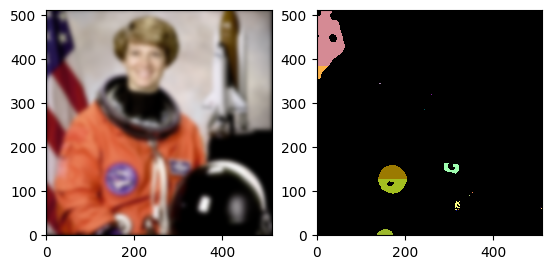

In [44]:
# make a colormap to display the labels as unique colors
# This doesn't actually guarantee uniqueness, since it wraps the list at some point
import matplotlib.colors as mcolors

colors_list = list(mcolors.XKCD_COLORS.keys())
# colors_list.remove("black")
colormap = mcolors.ListedColormap(colors=["black"] + colors_list * 101)

figure, axes = plt.subplots(1, 2)
axes[0].imshow(
    zarr.open("sample_data.zarr", "r")["smoothed_for_seg"][:].transpose(1, 2, 0),
    origin="lower",
)
blue_objs = zarr.open("sample_data.zarr", "r")["blue_objects"][:]
axes[1].imshow(blue_objs, origin="lower", cmap=colormap, interpolation="nearest")

Now we know how to chain tasks together, but we've created another issue. If objects crossed block boundaries, they were assigned different IDs. We will address this problem in the next section.

###Process functions that need to read their neighbor's output (and the "read_write_conflict" flag)

There is a class of problem where it is useful for a block to see the output of its neighboring blocks. Usually, this need comes up when the task performs detection and linking in the same step. To detect an object in a block, it is useful to know if a neighbor has already detected an object that the object in the current block should link to. This is especially useful if there is some sort of continuity constraint, as in tracking objects over time. Even for tasks without a continuity constraint, like agglomeration of fragments for instance segmentation, performing the detection and linking at the same time can save you an extra pass over the dataset, which matters when the datasets are large.

The example in this tutorial is only to illustrate how daisy implements the ability to depend on neighboring blocks outputs, by showing how we can relabel the segmentation IDs to be consistent across blocks during the detection step. Let's visualize an example block as though it were not completed, but its neighbors are done, and the read_roi is expanded by a certain amount of context.

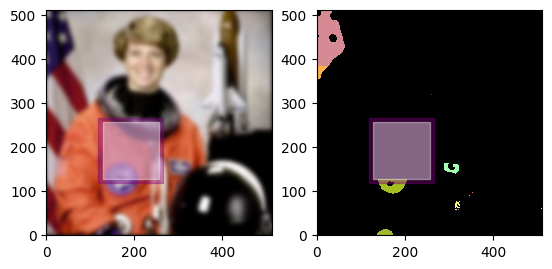

In [45]:
context = 10  # It could be as low as 1, but we use 10 for ease of visualization
seg_block_roi = daisy.Roi((128, 128), (128, 128))
seg_read_roi = seg_block_roi.grow(context, context)
seg_write_roi = seg_block_roi
seg_total_read_roi = total_roi.grow(context, context)

seg_block = daisy.Block(
    total_roi=seg_total_read_roi,
    read_roi=seg_read_roi,
    write_roi=seg_write_roi,
)

# simulate this block not being completed yet
blue_objs = zarr.open("sample_data.zarr", "r")["blue_objects"][:]
blue_objs[128:356, 128:256] = 0


figure, axes = plt.subplots(1, 2)
axes[0].imshow(
    zarr.open("sample_data.zarr", "r")["smoothed_for_seg"][:].transpose(1, 2, 0),
    origin="lower",
)
axes[1].imshow(blue_objs, origin="lower", cmap=colormap, interpolation="nearest")
display_roi(figure.axes[0], seg_block.read_roi, color="purple")
display_roi(figure.axes[0], seg_block.write_roi, color="white")
display_roi(figure.axes[1], seg_block.read_roi, color="purple")
display_roi(figure.axes[1], seg_block.write_roi, color="white")

Here the purple is the read_roi of our current block, and the white is the write_roi. As before, the process function will read the input image in the read_roi and segment it. From the previous result visualization, we can see that the function will detect the top half of the crest and assign it the label id that is visualized as brown.

Before we write out the brown label to the write_roi of the output dataset, however, we can adapt the process function to **also read in the existing results in the output dataset** in the read_roi. The existing green label will then overlap with the brown label, and our process function can relabel the top half of the crest green based on this information, before writing to the write_roi.

This approach only works if the overlapping blocks are run sequentially (and if objects don't span across non-adjacent blocks - for large objects, you cannot relabel without a second pass). If the neighbors are run in parallel, it is possible that the green label will not yet be there when our current block reads existing labels, but also that our brown label will not yet be there when the block containing the green object reads existing labels. If `read_write_conflicts` argument is set to True in a task, the daisy scheduler will ensure that pairs of blocks with overlapping read/write rois will never be run at the same time, thus avoiding this race condition.

In [46]:
# here is the new and improved segmentation function that reads in neighboring output context
def segment_blue_objects_with_context(input_group, output_group, block):
    import cv2
    from funlib.persistence.arrays import open_ds, Array
    import numpy as np
    import skimage
    import time

    def get_overlapping_labels(array1, array2):
        """A function to get all pairs of labels that intsersect between two arrays"""
        array1 = array1.flatten()
        array2 = array2.flatten()
        # get indices where both are not zero (ignore background)
        # this speeds up computation significantly
        non_zero_indices = np.logical_and(array1, array2)
        flattened_stacked = np.array(
            [array1[non_zero_indices], array2[non_zero_indices]]
        )
        intersections = np.unique(flattened_stacked, axis=1)
        return intersections  # a <number of pairs> x 2 nparray

    # load the data as usual
    input_ds = open_ds(
        f"sample_data.zarr/{input_group}",
        "r",
    )
    data = input_ds.to_ndarray(
        block.read_roi, fill_value=0
    )  # add the fill value because context

    # massage the data into open cv hsv format :/
    back_to_skimage = (data.transpose(1, 2, 0) * 255).astype(np.uint8)
    cv2_image = cv2.cvtColor(
        skimage.util.img_as_ubyte(back_to_skimage), cv2.COLOR_RGB2BGR
    )
    hsv_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2HSV)

    # Define the color range for detection
    lower_blue = np.array([100, 30, 0])
    upper_blue = np.array([150, 255, 255])

    # Threshold the image to get only blue colors
    mask = cv2.inRange(hsv_image, lower_blue, upper_blue)  # this returns 0 and 255
    mask = mask.astype(np.uint32)
    mask = mask // 255  # turn into 0/1 labels

    # give each connected component its own instance segmentation label
    labels = skimage.measure.label(mask)

    # get a unique ID for each element in the whole volume (avoid repeats between blocks)
    max_number_obj = (
        128 * 128
    )  # This number is an upper bound on the maximum number of objects in a block
    block_id_mask = mask * (block.block_id[1] * max_number_obj)
    labels = labels + block_id_mask

    # load the existing labels in the output
    output_ds = open_ds(f"sample_data.zarr/{output_group}", "a")
    existing_labels = output_ds.to_ndarray(block.read_roi, fill_value=0)

    # if there are existing labels, change the label to match
    # note: This only works if objects never span multiple rows/columns.
    # If you have long objects like neurons, you need to do true agglomeration
    intersections = get_overlapping_labels(labels, existing_labels)
    for index in range(intersections.shape[1]):
        label, existing_label = intersections[:, index]
        # Change the label to the one that was already in the neighbor
        labels[labels == label] = existing_label

    time.sleep(
        0.5
    )  # included to show that read_write_conflicts=False leads to race conditions

    # center crop and save the output dataset
    output_array = Array(labels, offset=block.read_roi.offset, voxel_size=(1, 1))
    output_ds[block.write_roi] = output_array.to_ndarray(block.write_roi)

In [47]:
seg_block_roi = daisy.Roi((0, 0), (128, 128))
seg_block_read_roi = seg_block_roi.grow(context, context)

delete_ds("blue_objects_with_context")
prepare_ds(
    "sample_data.zarr/blue_objects_with_context",
    shape=total_roi.shape,
    offset=total_roi.offset,
    voxel_size=daisy.Coordinate((1, 1)),
    dtype=np.uint32,
    write_size=seg_block_roi.shape,
)

seg_task = daisy.Task(
    "segmentation_with_context",
    process_function=partial(
        segment_blue_objects_with_context,
        "smoothed_for_seg",
        "blue_objects_with_context",
    ),
    total_roi=total_read_roi,
    read_roi=seg_block_read_roi,
    write_roi=seg_block_roi,
    read_write_conflict=True,  # this ensures neighboring blocks aren't run at the same time
    num_workers=10,
    upstream_tasks=[smoothing_task],
)
daisy.run_blockwise([seg_task])

/home/runner/work/daisy/daisy/.venv/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'write_size'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


segmentation_with_context ▶:   0%|          | 0/16 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task smooth_for_seg:

    num blocks : 64
    completed ✔: 64 (skipped 64)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully

  Task segmentation_with_context:

    num blocks : 16
    completed ✔: 16 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully


True

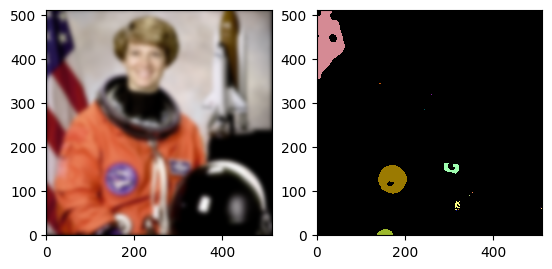

In [48]:
figure, axes = plt.subplots(1, 2)
axes[0].imshow(
    zarr.open("sample_data.zarr", "r")["smoothed_for_seg"][:].transpose(1, 2, 0),
    origin="lower",
)
axes[1].imshow(
    zarr.open("sample_data.zarr", "r")["blue_objects_with_context"][:],
    cmap=colormap,
    interpolation="nearest",
    origin="lower",
)

All the labels are now consistent! If you re-run the previous cell with `read_write_conflict=False`, you should see an inconsistent result again due to the race conditions, even though the process function still reads the neighboring output.

**IMPORTANT PERFORMANCE NOTE:** Be aware that `read_write_conflicts` is set to `True` by default and can lead to performance hits in cases where you don't need it, so be sure to turn it off if you want every block to be run in parallel!

# Some Minimal Examples

## Introduction and overview

In this tutorial we will cover some basic Daisy `Task`s

**daisy.Task**: All code you would like to distribute into blocks must be wrapped into a `Task` to be executed by daisy.


## Environment setup
If you have not already done so, I highly recommend you create an environment first.
You can do this with `uv` via:

```bash
uv init --python 3.12
```
Activating the environment is as simple as `source .venv/bin/activate`

Then, you can:
- add daisy directly to your dependencies with:
    ```bash
    uv add daisy
    ```
- install daisy using pip by name or via GitHub:
    ```bash
    pip install daisy
    ```



### Multiprocessing
Here we set the start method to fork. We do this to simplify running
this notebook in a jupyter notebook. The "spawn" start method is
supported but limits the possible functions you can execute blockwise
(i.e. no lambda functions)

In [49]:
import multiprocessing

multiprocessing.set_start_method("fork", force=True)

## Daisy Tasks

### A Simple Task

In [50]:
import daisy
from daisy import Coordinate, Roi
import time

# Create a super simple task
dummy_task = daisy.Task(
    "Dummy",  # We give the task a name
    total_roi=Roi((0,), (100,)),  # a 1-D bounding box [0,100)
    read_roi=Roi((0,), (1,)),  # We read in blocks of size [0,1)
    write_roi=Roi((0,), (1,)),  # We write in blocks of size [0, 1)
    process_function=lambda block: time.sleep(
        0.05
    ),  # Our process function takes the block and simply waits
    num_workers=5,
)

# execute the task without any multiprocessing
daisy.run_blockwise([dummy_task], multiprocessing=False)
daisy.run_blockwise([dummy_task], multiprocessing=True)

Dummy ▶:   0%|          | 0/100 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task Dummy:

    num blocks : 100
    completed ✔: 100 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully


Dummy ▶:   0%|          | 0/100 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task Dummy:

    num blocks : 100
    completed ✔: 100 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully


True

Since there are 100 blocks to process, and we always sleep for 0.05 seconds, it takes 5 seconds
to run all the blocks without multiprocessing, but only 1 second with `multiprocessing=True`.
When you run a task with `daisy`, you get a progress bar along with a summary
of the execution after you have finished processing. Here no errors were thrown so we completed all 100 blocks.

`daisy` also programatically returns a dictionary containing a summary of the execution for all given
tasks so that you can decide how to procede based on whether any blocks failed.

Next lets look see what we can do to modify this task

### Failing blocks

In [51]:

import random


def random_fail(block: daisy.Block):
    if random.random() < 0.2:
        block.status = daisy.BlockStatus.FAILED
    return block


# Create a super simple task
failing_task = daisy.Task(
    "Failures",  # We give the task a name
    total_roi=Roi((0,), (100,)),  # a 1-D bounding box [0,100)
    read_roi=Roi((0,), (1,)),  # We read in blocks of size [0,1)
    write_roi=Roi((0,), (1,)),  # We write in blocks of size [0, 1)
    process_function=random_fail,  # Our process function takes the block and simply waits
    max_retries=0,  # We do not retry failed blocks to get expected failure counts
)

# execute the task without any multiprocessing
daisy.run_blockwise([failing_task], multiprocessing=False)

Failures ▶:   0%|          | 0/100 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task Failures:

    num blocks : 100
    completed ✔: 83 (skipped 0)
    failed    ✗: 17
    orphaned  ∅: 0



defaultdict(daisy.task_state.TaskState,
            {'Failures': Started: True
             Total Blocks: 100
             Ready: 0
             Processing: 0
             Pending: 0
             Completed: 83
             Skipped: 0
             Failed: 17
             Orphaned: 0})


In this case, we have a 20% chance of failing each block. As you see from the execution summary,
about 20% of the blocks failed.
If your blocks are failing, you may want to rerun the task and only process failed blocks. This
is where we use the `check_function` argument in the `daisy.Task`.

In [52]:
import tempfile
from pathlib import Path

with tempfile.TemporaryDirectory() as tmpdir:

    def random_fail(block: daisy.Block):
        if random.random() < 0.2:
            block.status = daisy.BlockStatus.FAILED
        else:
            Path(tmpdir, f"{block.block_id[1]}").touch()
        return block

    def check_block(block: daisy.Block) -> bool:
        return Path(tmpdir, f"{block.block_id[1]}").exists()

    while True:
        # Create a super simple task
        check_block_task = daisy.Task(
            "Checking-Blocks",  # We give the task a name
            total_roi=Roi((0,), (100,)),  # a 1-D bounding box [0,100)
            read_roi=Roi((0,), (1,)),  # We read in blocks of size [0,1)
            write_roi=Roi((0,), (1,)),  # We write in blocks of size [0, 1)
            process_function=random_fail,  # Our process function takes the block and simply waits
            check_function=check_block,  # Check if a block has been completed or not
            max_retries=0,
        )

        # execute the task without any multiprocessing
        task_state = daisy.run_blockwise([check_block_task], multiprocessing=False)
        if task_state["Checking-Blocks"].failed_count == 0:
            break

Checking-Blocks ▶:   0%|          | 0/100 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task Checking-Blocks:

    num blocks : 100
    completed ✔: 84 (skipped 0)
    failed    ✗: 16
    orphaned  ∅: 0



Checking-Blocks ▶:   0%|          | 0/100 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task Checking-Blocks:

    num blocks : 100
    completed ✔: 97 (skipped 84)
    failed    ✗: 3
    orphaned  ∅: 0



Checking-Blocks ▶:   0%|          | 0/100 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task Checking-Blocks:

    num blocks : 100
    completed ✔: 100 (skipped 97)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully



It took a few tries to complete the task since approximately 20% of the remaining blocks fail
on each attempt. We could also have set `max_retries` to a higher number to allow for retrying failed
blocks during the same task execution. This is to account for random failures due to network issues or
other random uncontrollable factors, but will not help if there is a logical bug in your code. In this
case since the failure is random, retrying does help.

### Different read/write sizes and boundary handling

In [53]:

# fit: "valid", "overhang", "shrink"

# Create a super simple task
overhang_task = daisy.Task(
    "overhang",  # We give the task a name
    total_roi=Roi((0,), (100,)),  # a 1-D bounding box [0,100)
    read_roi=Roi((0,), (9,)),  # We read in blocks of size [0,1)
    write_roi=Roi((2,), (5,)),  # We write in blocks of size [0, 1)
    process_function=lambda b: ...,  # Empty process function
    fit="overhang",
)
valid_task = daisy.Task(
    "valid",  # We give the task a name
    total_roi=Roi((0,), (100,)),  # a 1-D bounding box [0,100)
    read_roi=Roi((0,), (9,)),  # We read in blocks of size [0,1)
    write_roi=Roi((2,), (5,)),  # We write in blocks of size [0, 1)
    process_function=lambda b: ...,  # Empty process function
    fit="valid",
)

because we now have:

total roi: [0, 100)

read roi: [0, 9)

write roi: [2, 7)

There is a "context" of 2 pixels between the read_roi and write roi.
Removing this context from the total roi gives us a "total write roi" of [2, 98).
Note that the total number of pixels to tile is 96, which is not evenly divisible
by the chunk size of 5. So our final block will have write roi of [97, 102) and a
read roi of [95, 104). Depending on your task, reading, and especially writing outside
of the given total roi bounds can cause problems.
in these cases we can handle the final block in a few ways. "valid": ignore the
final block. "overhang": process the final block. "shrink": shrink the read/write
rois until the read roi is fully contained in the total roi. In this case the "shrink"
strategy would shrink the read roi to [95, 100) and the write roi to [97, 98).

Now when we executing the overhang task it will have one more block processed than the
valid task

In [54]:
daisy.run_blockwise([overhang_task], multiprocessing=False)
daisy.run_blockwise([valid_task], multiprocessing=False)

overhang ▶:   0%|          | 0/20 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task overhang:

    num blocks : 20
    completed ✔: 20 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully


valid ▶:   0%|          | 0/19 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task valid:

    num blocks : 19
    completed ✔: 19 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully


defaultdict(daisy.task_state.TaskState,
            {'valid': Started: True
             Total Blocks: 19
             Ready: 0
             Processing: 0
             Pending: 0
             Completed: 19
             Skipped: 0
             Failed: 0
             Orphaned: 0})

### Task Chaining

It is also possible to chain multiple tasks together in such a way that
they either run in parallel or in sequence. If running in parallel, we
simply start the workers for both tasks at once. If running in sequence,
blocks will only be realeased once their dependencies in previous tasks
have been completed.

In [55]:
total_roi = Roi((0, 0), (1250, 1250))
read_roi_shape = (400, 400)
write_roi_shape = (250, 250)
context = Coordinate(75, 75)

task_a_to_b = daisy.Task(
    "A_to_B",
    total_roi=total_roi.grow(
        context,
        context,
    ),
    read_roi=Roi((0, 0), read_roi_shape),
    write_roi=Roi(context, write_roi_shape),
    process_function=lambda b: ...,
    read_write_conflict=False,
)
task_b_to_c = daisy.Task(
    "B_to_C",
    total_roi=total_roi.grow(
        context,
        context,
    ),
    read_roi=Roi((0, 0), read_roi_shape),
    write_roi=Roi(context, write_roi_shape),
    process_function=lambda b: ...,
    read_write_conflict=False,
    upstream_tasks=[task_a_to_b],
)

daisy.run_blockwise([task_a_to_b, task_b_to_c], multiprocessing=False)

A_to_B ▶:   0%|          | 0/25 [00:00<?, ?blocks/s]

B_to_C ▶:   0%|          | 0/25 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task A_to_B:

    num blocks : 25
    completed ✔: 25 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully

  Task B_to_C:

    num blocks : 25
    completed ✔: 25 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully


defaultdict(daisy.task_state.TaskState,
            {'A_to_B': Started: True
             Total Blocks: 25
             Ready: 0
             Processing: 0
             Pending: 0
             Completed: 25
             Skipped: 0
             Failed: 0
             Orphaned: 0,
             'B_to_C': Started: True
             Total Blocks: 25
             Ready: 0
             Processing: 0
             Pending: 0
             Completed: 25
             Skipped: 0
             Failed: 0
             Orphaned: 0})


Here is an mp4 visualization of the above task

![task chaining](_static/task_chaining.gif)

# Map Reduce and Some simple benchmarks

## Simple data

In [56]:
import numpy as np
import timeit

shape = 4096000

a = np.arange(shape, dtype=np.int64)
b = np.empty_like(a, dtype=np.int64)
print(f"Array a: {a[:6]} ...")

Array a: [0 1 2 3 4 5] ...


## Map
Here we will square each element in the array `a` and store the result in a new array `b`

In [57]:
def process_fn():
    # iterating and squaring each element in a and store to b
    with np.nditer([a, b], op_flags=[["readonly"], ["readwrite"]]) as it:
        with it:
            for x, y in it:
                y[...] = x**2


print(f"Squaring array a took {timeit.timeit(process_fn, number=1)} seconds")
print(f"Array b: {b[:6]} ...")

Squaring array a took 3.258563630000026 seconds
Array b: [ 0  1  4  9 16 25] ...


In [58]:
import daisy
from funlib.persistence import Array
import zarr

shape = 4096000
block_shape = 1024 * 16

# input array is wrapped in Array for easy of Roi indexing
a = Array(
    np.arange(shape, dtype=np.int64),
    offset=(0,),
    voxel_size=(1,),
)

# to parallelize across processes, we need persistent read/write arrays
# we'll use zarr here to do do that
b = zarr.open_array(
    zarr.TempStore(), "w", (shape,), chunks=(block_shape,), dtype=np.int64
)
# output array is wrapped in Array for easy of Roi indexing
b = Array(
    b,
    offset=(0,),
    voxel_size=(1,),
)

In [59]:
# same process function as previously, but with additional code
# to read and write data to persistent arrays
def process_fn_daisy(block):
    a_sub = a[block.read_roi]
    b_sub = np.empty_like(a_sub)
    with np.nditer(
        [a_sub, b_sub],
        op_flags=[["readonly"], ["readwrite"]],
    ) as it:
        with it:
            for x, y in it:
                y[...] = x**2

    b[block.write_roi] = b_sub

In [60]:
total_roi = daisy.Roi((0,), shape)  # total ROI to map process over
block_roi = daisy.Roi((0,), (block_shape,))  # block ROI for parallel processing

# creating a Daisy task, note that we do not specify how each
# worker should read/write to input/output arrays
task = daisy.Task(
    total_roi=total_roi,
    read_roi=block_roi,
    write_roi=block_roi,
    process_function=process_fn_daisy,
    num_workers=8,
    task_id="square",
)

daisy.run_blockwise([task])
print(f"Array b: {b[:6]} ...")

square ▶:   0%|          | 0/250 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task square:

    num blocks : 250
    completed ✔: 250 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully
Array b: [ 0  1  4  9 16 25] ...


In [61]:
# run this to benchmark daisy!
run_daisy = lambda: daisy.run_blockwise([task])
print(f"Squaring array a with daisy took {timeit.timeit(run_daisy, number=1)} seconds")

square ▶:   0%|          | 0/250 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task square:

    num blocks : 250
    completed ✔: 250 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully
Squaring array a with daisy took 2.3006694119999906 seconds


## Reduce
Here we will take the sum over every 16 elements in the array `b` and store the result in a new array `c`

In [62]:
import multiprocessing

reduce_shape = shape / 16

# while using zarr with daisy.Array can be easier to understand and less error prone, it is not a requirement.
# Here we make a shared memory array for collecting results from different workers
c = multiprocessing.Array("Q", range(int(shape / reduce_shape)))


def process_fn_sum_reduce(block):
    b_sub = b[block.write_roi]
    s = np.sum(b_sub)
    # compute c idx based on block offset and shape
    idx = (block.write_roi.offset / block.write_roi.shape)[0]
    c[idx] = s


total_roi = daisy.Roi((0,), shape)  # total ROI to map process over
block_roi = daisy.Roi((0,), reduce_shape)  # block ROI for parallel processing

task1 = daisy.Task(
    total_roi=total_roi,
    read_roi=block_roi,
    write_roi=block_roi,
    process_function=process_fn_sum_reduce,
    num_workers=8,
    task_id="sum_reduce",
)

daisy.run_blockwise([task1])
print(c[:])

sum_reduce ▶:   0%|          | 0/16 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task sum_reduce:

    num blocks : 16
    completed ✔: 16 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully
[5592372565376000, 39146739029376000, 106255537493376000, 206918767957376000, 341136430421376000, 508908524885376000, 710235051349376000, 945116009813376000, 1213551400277376000, 1515541222741376000, 1851085477205376000, 2220184163669376000, 2622837282133376000, 3059044832597376000, 3528806815061376000, 4032123229525376000]
